In [87]:
#!pip install statsmodels
import numpy as np
import pandas as pd
from pandas import Series
import datetime
from sklearn import linear_model
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [88]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)

In [177]:
def get_products_bought_in_week(week_number, df, sessions_df):
    products = []
    x = df.loc[df['weeks_from_start'] == week_number].index.values
    start = x[0]
    product_list = list(sessions_df['product_id'])
    end = start + np.timedelta64(6,'D')
    sessions_df = sessions_df[(sessions_df['event_type'] == "BUY_PRODUCT")]
    for i, date in enumerate(sessions_df['timestamp']):
        date = np.datetime64(date)
        if start <= date <= end:
            products.append(product_list[i])
    return products

In [89]:
def create_weeks(df):
    dates = df['timestamp']
    dates = pd.to_datetime(dates)
    dates = dates.dt.to_period('W')
    dates = dates.drop_duplicates()
    dates = dates.sort_values()
    return dates

In [178]:
def split_data(y, split_ratio = 0.8):
    split_n = int(split_ratio*len(y))
    train = y.iloc[:split_n]
    test = y.iloc[split_n:]
    return train, test

In [90]:
def calculate_week_number(date = datetime.date.today()):
    first_date = create_weeks(sessions_df).values[0].start_time.date()
    return (date - first_date).days//7

In [91]:
def product_bought(product_id, df, dates):
    product_amount = df[(df['event_type'] == "BUY_PRODUCT") & (df['product_id'] == product_id)]
    daterange_df = pd.DataFrame()
    time_list = [(dates.values[i].start_time, dates.values[i].end_time) for i in range(len(dates))]
    daterange_df['count'] = [product_amount['timestamp'].between(s, e).sum() for s, e in time_list]
    return daterange_df

In [92]:
def prepare_dataframe(df):
    dates = create_weeks(df)
    weeks = dates.values
    df3 = pd.DataFrame()
    df3['date'] = [weeks[i].start_time for i in range(len(weeks))]
    df2 = pd.DataFrame(index = df3['date'])
    df2['weeks_from_start'] = ((df2.index - df2.index[0]).days)//7
    return df2, dates

In [93]:
def prepare_data(product_id, df, source_df, dates):
    x = df['weeks_from_start'].values.reshape(-1, 1)
    y = product_bought(product_id, source_df, dates)['count'].values
    return x, y

In [180]:
def fit_model(dataset):
    model=ARIMA(dataset, order=(1,1,1))
    model_fit=model.fit()
    return model_fit

In [182]:
def get_model_summary(model):
    return model.summary()

In [183]:
def add_empty_rows(df, amount):
    for i in range(amount):
        df.loc[len(df)] = 0
    return df

In [184]:
def plot_autocorrelation(dataset):
    autocorrelation_plot(dataset)
    plt.show()

In [189]:
def predict(start_week, end_week, df, model):
    if end_week > len(df):
        add_empty_rows(df, len(df)-end_week)
    df['forecast']=model.predict(start=start_week,end=end_week,dynamic=True)
    return df

ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


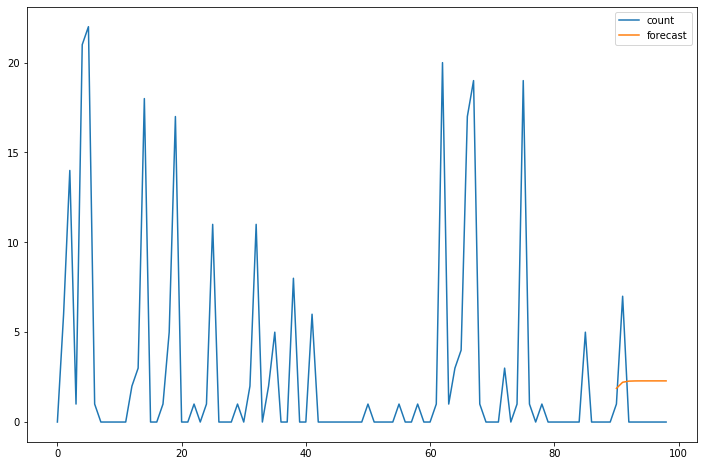

In [190]:
df, dates = prepare_dataframe(sessions_df)
# x, y = prepare_data(1291, df, sessions_df, dates)
y = product_bought(1291, sessions_df, dates)
train, test = split_data(y)
model_fit = fit_model(train['count'])

predicted = predict(90, 150, train, model_fit)
predicted[['count','forecast']].plot(figsize=(12,8))